In [445]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, callbacks

In [446]:
PASTA_FOURIER = "data/fourier/"
MODEL_NAME = 'segundo_treino.keras'

In [447]:
def parse_data(example):
    parsed = tf.io.parse_sequence_example(example,  {
        "label": tf.io.FixedLenFeature(shape=7, dtype=tf.float32),
        "data" : tf.io.FixedLenFeature(shape=(20,100,2), dtype=tf.float32)
    })

    return parsed[0]["data"], parsed[0]["label"]

In [448]:
def get_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames).map(parse_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=8192)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    dataset = dataset.batch(128)

    return dataset

In [449]:
# reg = tf.keras.regularizers.L1L2(l1=1, l2=1)
# reg = tf.keras.regularizers.l1()
# reg = tf.keras.regularizers.L2(l2=0.00000001)
reg=None
act = "leaky_relu"

model = models.Sequential()
model.add(layers.Conv2D(8, (2, 2), activation=act, kernel_regularizer=reg, input_shape=(20, 100, 2)))
model.add(layers.MaxPooling2D((2, 10)))
model.add(layers.Conv2D(16, (2, 2), activation=act, kernel_regularizer=reg))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (2, 2), activation=act, kernel_regularizer=reg))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=act, kernel_regularizer=reg))
model.add(layers.Dense(7, activation='softmax'))

# model=tf.keras.models.load_model(MODEL_NAME)


In [450]:
model.summary()

Model: "sequential_52"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_135 (Conv2D)             │ (None, 19, 99, 8)      │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_133               │ (None, 9, 9, 8)        │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_136 (Conv2D)             │ (None, 8, 8, 16)       │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_134               │ (None, 4, 4, 16)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_137 (Conv2D)             │ (None, 3, 3, 32)       │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_135               │ (None, 1, 1, 32)       │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_49 (Flatten)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_132 (Dense)               │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_133 (Dense)               │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,967 (15.50 KB)

 Trainable params: 3,967 (15.50 KB)

 Non-trainable params: 0 (0.00 B)

In [451]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.CategoricalCrossentropy()
)

In [454]:
validate = get_dataset( PASTA_FOURIER + 'data_0' ) 
# train = get_dataset( [PASTA_FOURIER + '1', PASTA_FOURIER + '2', PASTA_FOURIER + '3'] ) 
train = get_dataset( PASTA_FOURIER + 'data_0' ) 

In [455]:
history = model.fit(
    train,
    epochs=1,
    # batch_size=10,
    # steps_per_epoch=2700,
    # shuffle=True,
    validation_data = validate,
    # validation_steps=100,
    verbose= 1,
    callbacks = [
         callbacks.EarlyStopping(monitor="val_loss", patience=2),
         callbacks.ModelCheckpoint(MODEL_NAME, save_best_only = True)
    ]
)


    469/Unknown 11s 23ms/step - loss: 18.7671

2024-04-14 22:22:18.171251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


470/470 ━━━━━━━━━━━━━━━━━━━━ 17s 35ms/step - loss: 18.7373 - val_loss: 7.9672


2024-04-14 22:22:23.663556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [456]:
model(next(iter(validate)))

<tf.Tensor: shape=(128, 7), dtype=float32, numpy=
array([[2.88651676e-12, 1.63553547e-22, 1.05977004e-15, 7.07006358e-34,
        9.30988446e-12, 9.99999940e-01, 7.31177532e-12],
       [4.40154225e-02, 3.31344783e-01, 1.10715054e-01, 8.25274959e-02,
        4.10297140e-02, 3.31380248e-01, 5.89874052e-02],
       [9.31058079e-02, 2.31015116e-01, 1.21685185e-01, 1.14823811e-01,
        1.09613813e-01, 1.54150322e-01, 1.75605997e-01],
       [6.91455379e-02, 3.06475192e-01, 1.80111900e-01, 1.11982644e-01,
        6.05847277e-02, 1.88670114e-01, 8.30298439e-02],
       [3.43139693e-02, 2.45739192e-01, 5.88693991e-02, 3.08533192e-01,
        3.82398628e-02, 1.90387517e-01, 1.23916671e-01],
       [7.41887912e-02, 3.43867868e-01, 1.04362890e-01, 1.38505474e-01,
        7.82696903e-02, 1.56004906e-01, 1.04800314e-01],
       [8.30637850e-03, 5.58059752e-01, 1.52449414e-01, 1.46965933e-04,
        1.12373114e-01, 1.13748983e-01, 5.49153350e-02],
       [2.30669245e-01, 1.22119971e-01, 1.83268

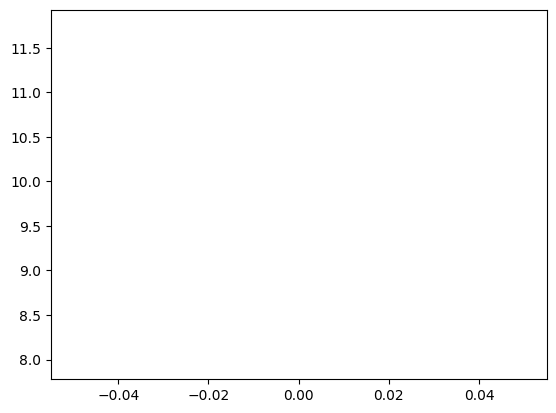

In [457]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], color='red')